# Определение возраста покупателей

Сетевой супермаркет "Хлеб-соль" внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
- контролировать добросовестность кассиров при продаже алкоголя.  
Задача проекта: построить модель, которая по фотографии определит приблизительный возраст человека.  
Имеющиеся данные: набор фотографий людей с указанием возраста.  

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `/datasets/faces/`. 
В нашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

План работы:  
1. Провести исследовательский анализ данных:  
    - посмотреть на размер выборки;  
    - построить график распределения возраста в выборке;  
    - вывести на экран несколько фотографий и посмотреть, как устроен датасет.  
2. Подготовить данные к обучению.  
3. Обучить нейронную сеть и рассчитать её качество.

## Подготовка к загрузке данных

Целевой признак - возраст человека, следовательно, перед нами стоит задача регрессии. Нужно построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей. Метрикой качества будет MAE. Необходимо, чтобы её значение было не больше 8.

In [1]:
# Загрузим базовые библиотеки
import pandas as pd
import numpy as np

# Импорт библиотек для нейросети
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Загрузим библиотеки для графики
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Создадим переменную
faces_way = '/datasets/faces/'

## Загрузка и исследовательский анализ данных

### Анализ датафрейма
Рассмотрим CSV-файл `labels.csv`.

In [3]:
# Загрузим датафрейм и созраним его в переменную `data`
data = pd.read_csv(faces_way + 'labels.csv')

# Выведем на экран первые 5 строк датафрейма
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Данные загрузились корректно.

In [4]:
# Рассмотрим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датафрейме 7591 строка и 2 столбца: `file_name` (название изображения, а именно его номер, тип данных `object`) и `real_age` (возраст человека на изображении, тип данных `int64`, возраст в годах). Пропусков нет. 

In [5]:
# Получим информацию о распределении признака
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Минимальное значение возраста 1 год, максимальное - 100 лет. Среднее значение возраста 31 год, медианное - 29 лет. Половина людей на изображениях имеет возраст от 20 до 41 лет. Разброс значений возраста большой.  
Изобразим графически распределение изображений по возрастам, используем гистограмму, число корзин возьмём соответствующим размаху признака, т.е. 100.

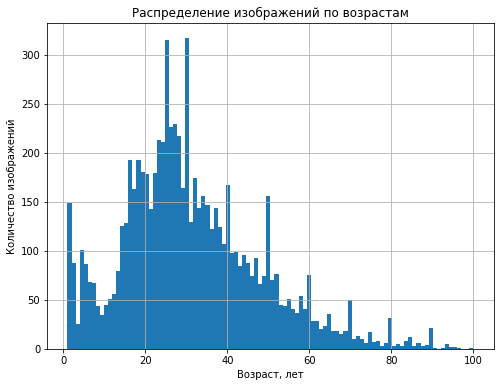

In [6]:
# Построим гистограмму распределения
data.hist(bins=100, figsize=(8, 6))
plt.title('Распределение изображений по возрастам')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество изображений')
plt.show()

Распределение похоже на нормальное. Имеется правосторонняя асимметрия, пик распределения смещён влево.  
Пик распределения находится в значениях около 25-30 лет, что близко к медианному значению. Ещё один значительный пик находится в минимальных значениях возраста.  
Кроме того, начиная с пикового значения далее имеются отдельные всплески в значениях, кратных пяти. Возможно, это последствия каких-либо округлений в первичных данных.

### Анализ папки с изображениями
Рассмотрим папку с изображениями `/final_files`. Выберем одно изображение, посмотрим на его размерность.

In [7]:
# Рассмотрим первое изображение информацию о нём из датасета `data`
# указываем файл
file_0 = faces_way + 'final_files/000000.jpg' 

image_0 = Image.open(file_0)
array_0 = np.array(image_0)
print('Файл       :', data.loc[0, 'file_name'])
print('Возраст    :', data.loc[0, 'real_age'])
print('Размерность:', array_0.shape) 
print() 
print(array_0)

Файл       : 000000.jpg
Возраст    : 4
Размерность: (114, 114, 3)

[[[129  70  36]
  [168 112  77]
  [169 115  77]
  ...
  [150 103  83]
  [157 110  94]
  [158 111  95]]

 [[133  77  42]
  [162 106  71]
  [165 111  73]
  ...
  [171 123 103]
  [169 124 105]
  [169 124 105]]

 [[118  62  29]
  [129  73  40]
  [131  77  41]
  ...
  [187 134 116]
  [180 135 112]
  [180 135 112]]

 ...

 [[112  65  19]
  [115  68  22]
  [119  72  26]
  ...
  [211 155  70]
  [191 140  57]
  [191 140  57]]

 [[115  74  30]
  [102  61  17]
  [ 96  55   9]
  ...
  [202 142  56]
  [192 135  56]
  [199 142  63]]

 [[113  72  28]
  [ 99  58  14]
  [ 94  53   7]
  ...
  [195 135  49]
  [192 135  56]
  [199 142  63]]]


Выведем на экран первые 15 изображений, а также информацию о них.

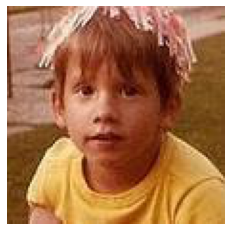

Файл       : 000000.jpg
Возраст    : 4
Размерность: (114, 114, 3)



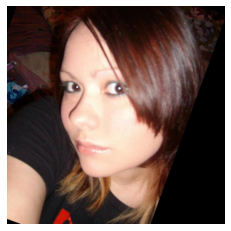

Файл       : 000001.jpg
Возраст    : 18
Размерность: (784, 784, 3)



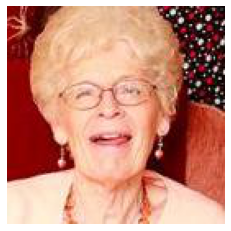

Файл       : 000002.jpg
Возраст    : 80
Размерность: (133, 133, 3)



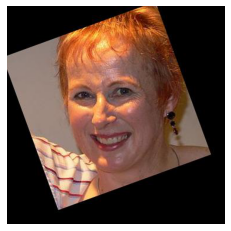

Файл       : 000003.jpg
Возраст    : 50
Размерность: (370, 370, 3)



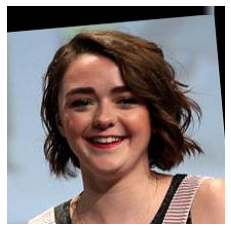

Файл       : 000004.jpg
Возраст    : 17
Размерность: (212, 212, 3)



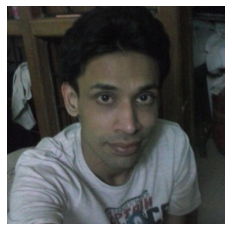

Файл       : 000005.jpg
Возраст    : 27
Размерность: (636, 637, 3)



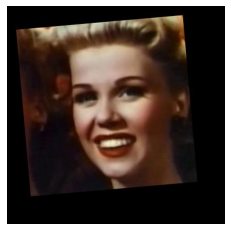

Файл       : 000006.jpg
Возраст    : 24
Размерность: (412, 412, 3)



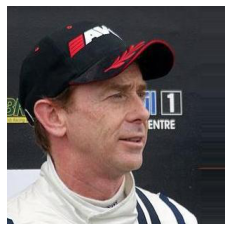

Файл       : 000007.jpg
Возраст    : 43
Размерность: (311, 311, 3)



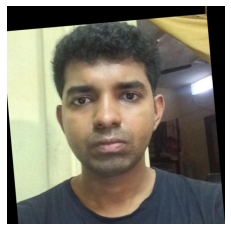

Файл       : 000008.jpg
Возраст    : 26
Размерность: (898, 897, 3)



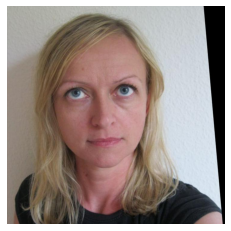

Файл       : 000009.jpg
Возраст    : 39
Размерность: (724, 724, 3)



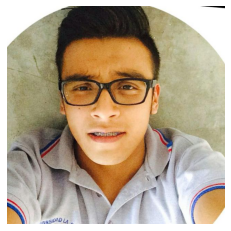

Файл       : 000010.jpg
Возраст    : 17
Размерность: (636, 636, 3)



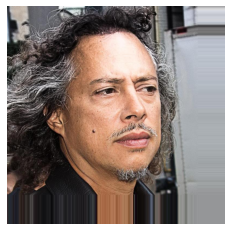

Файл       : 000011.jpg
Возраст    : 51
Размерность: (803, 803, 3)



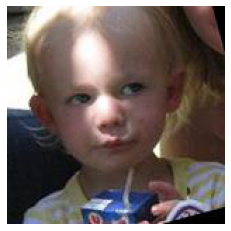

Файл       : 000012.jpg
Возраст    : 2
Размерность: (155, 155, 3)



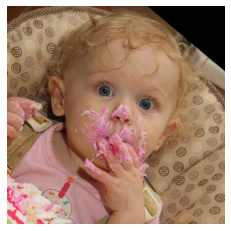

Файл       : 000013.jpg
Возраст    : 1
Размерность: (321, 321, 3)



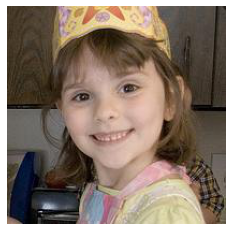

Файл       : 000014.jpg
Возраст    : 6
Размерность: (203, 204, 3)



In [8]:
for i in range(0, 15):
    # указываем файл, учитываем количество разрядов в номерах изображений
    if i < 10:
        file_num = faces_way + 'final_files/00000'+ str(i) + '.jpg'
    elif i < 100:
        file_num = faces_way + 'final_files/0000'+ str(i) + '.jpg'
    # записываем файл в переменную
    image = Image.open(file_num)
    # переводим в массив
    array = np.array(image)
    # выводим изображение на экран
    plt.imshow(array)
    plt.axis('off')
    plt.show()
    # выведем информацию о файле
    print('Файл       :', data.loc[i, 'file_name'])
    print('Возраст    :', data.loc[i, 'real_age'])
    print('Размерность:', array.shape) 
    print()

На фотографиях, действительно, изображены лица людей разного возраста и пола, в разной обстановке, с разным фоном. Изображения расположены корректно, лица на фотографиях расположены по центру, размер лиц по отношению к общей площади фотографии выдержан в нужной пропорции, необходимости в обрезке нет. Рассмотренные изображения размечены верно, возраст соответствует изображениям. Размер фотографий в пикселях различный, но он имеет квадратный размер. Изображения имеют три цветовых канала. Формат файлов `.ipg`.

**Выводы по загрузке и исследованию данных.**

1. Данные включают в себя 7591 изображения лиц людей разного возраста и пола, с разным фоном, освещением, квадратного размера с разным размером в пикселях. Изображения имеют три цветовых канала RGB.  
2. Количество данных должно быть достаточным, если применить нейросеть, предобученную на большей выборке. Будем использовать предобученную свёрточную нейросеть `ResNet50`.
3. Изображения расположены в отдельных файлах формата `.jpg`, для работы с ними будем использовать `ImageDataGenerator` и его метод `flow_from_dataframe`.
4. При подготовке тренировочных данных будем использовать аугментацию: отражения, повороты.
5. Распределение данных близкое к нормальному, но имеются дополнительные пики и всплески.
6. Возраст людей на фотографиях варьируется от 1 до 100 лет. Больше всего в данных фотографий с изображениями людей в возрасте 25-30 лет. Изображения с такими возрастами будут предсказываться точнее.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке).  

(Перенесли сюда код обучения модели и её результат вывода на экран).

```python

# Функция загрузки и подготовки тренировочных данных
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    # применяем загрузчик данных и аугментацию
    train_datagen = ImageDataGenerator(
        vertical_flip=True,
        #horizontal_flip=True,
        rotation_range = 90,
        width_shift_range = 0.3,
        height_shift_range = 0.3,
        #zoom_range = [.6, .6],
        rescale=1./255,
        validation_split=.25
    )
    
    # вызываем извлечение данных из папки
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    # результат: возвращение загрузчика данных тренировочной выборки
    return train_datagen_flow

# Функция загрузки и подготовки тестовых данных
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    # применяем загрузчик данных
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.25
    )
    
    # вызываем извлечение данных из папки
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    # результат: возвращение загрузчика данных тренировочной выборки
    return test_datagen_flow

# Функция создания модели нейросети
def create_model(input_shape):
    # импортируем архитектуру ResNet 
    backbone = ResNet50(input_shape=input_shape,  
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    # инициализация модели
    model = Sequential()
    # добавление слоёв в модель
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    # подготовка модели к обучению
    optimizer = Adam(0.00005)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    # результат: возвращение настроенной модели
    return model

# Обучаем модель
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    # обучение модели
    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    # результат: возвращение обученной модели
    return model


```

```

# < скопировали результат вывода на экран сюда >

2024-07-13 15:13:46.296446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-07-13 15:13:46.298489: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-07-13 15:13:47.517884: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-13 15:13:47.525263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-07-13 15:13:47.525331: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-07-13 15:13:47.525371: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-13 15:13:47.527639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-07-13 15:13:47.528062: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-07-13 15:13:47.530564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-07-13 15:13:47.532096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-07-13 15:13:47.532150: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-13 15:13:47.536476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-07-13 15:13:48.380555: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-07-13 15:13:48.390794: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2024-07-13 15:13:48.391408: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c72320 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-13 15:13:48.391449: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-13 15:13:48.572533: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4b927d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-13 15:13:48.572572: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-07-13 15:13:48.574708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-07-13 15:13:48.574766: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-07-13 15:13:48.574781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-13 15:13:48.574807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-07-13 15:13:48.574824: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-07-13 15:13:48.574840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-07-13 15:13:48.574855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-07-13 15:13:48.574866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-13 15:13:48.578563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-07-13 15:13:48.578623: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-07-13 15:13:48.994924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-07-13 15:13:48.994967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-07-13 15:13:48.994977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-07-13 15:13:48.998962: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-13 15:13:48.999012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-07-13 15:14:04.433375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-13 15:14:05.045353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 135s - loss: 369.8511 - mean_absolute_error: 14.3742 - val_loss: 948.6678 - val_mean_absolute_error: 26.0182
Epoch 2/10
178/178 - 113s - loss: 150.1645 - mean_absolute_error: 9.2440 - val_loss: 1030.1111 - val_mean_absolute_error: 27.4255
Epoch 3/10
178/178 - 116s - loss: 125.2590 - mean_absolute_error: 8.5732 - val_loss: 853.2456 - val_mean_absolute_error: 24.0642
Epoch 4/10
178/178 - 110s - loss: 116.7376 - mean_absolute_error: 8.2209 - val_loss: 185.0304 - val_mean_absolute_error: 10.1688
Epoch 5/10
178/178 - 116s - loss: 106.8569 - mean_absolute_error: 7.8609 - val_loss: 126.4495 - val_mean_absolute_error: 8.3320
Epoch 6/10
178/178 - 113s - loss: 98.4586 - mean_absolute_error: 7.6098 - val_loss: 114.3744 - val_mean_absolute_error: 8.0313
Epoch 7/10
178/178 - 117s - loss: 90.9468 - mean_absolute_error: 7.2864 - val_loss: 122.3325 - val_mean_absolute_error: 8.4664
Epoch 8/10
178/178 - 113s - loss: 85.1238 - mean_absolute_error: 7.0929 - val_loss: 107.6973 - val_mean_absolute_error: 7.7935
Epoch 9/10
178/178 - 111s - loss: 79.1156 - mean_absolute_error: 6.8481 - val_loss: 100.9541 - val_mean_absolute_error: 7.6305
Epoch 10/10
178/178 - 122s - loss: 74.9596 - mean_absolute_error: 6.6251 - val_loss: 97.7775 - val_mean_absolute_error: 7.5185
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 97.7775 - mean_absolute_error: 7.5185
Test MAE: 7.5185

```

**Вывод по обучению модели.**  
1. Для решения поставленной задачи построена модель с использованием архитектуры `ResNet50` с оптимизацией алгоритмом `Adam(lr=0.00005)`.
2. Модель обучена, получено значение метрики на тестовых данных 7.5185, что соответствует поставленному условию.

## Анализ обученной модели

В результате работы нейросети на GPU значение метрики `MAE` на валидационных данных получено 7.5185, что ниже целевого значения 8. Полученное значение означает, что созданная модель ошибается в предсказании возраста человека по его фотографии в среднем на 7,5185 лет.  

Ошибка достаточно велика. Это может быть связано с исходными данными. Как мы выяснили при исследовательском анализе датасета, больше всего фотографий людей в возрасте 25-30 лет. Половина людей на изображениях имеет возраст от 20 до 41 лет. Поэтому возраст людей моложе 20 лет и старше 41 года может быть предсказан неточно, так как для этих возрастов данных недостаточно. Качество модели может быть лучше, если дополнить датасет фотографиями людей в возрасте до 20 лет и старше 41 года.  

Кроме того, нужно проверить, почему в данных имеются всплески в возрастах, кратных 5. Возможно, это округление возраста. Необходимо разметке возрастных значений уделить больше внимания и провести её точнее.  

Переобучения модели не наблюдается, так как значение метрик на валидационной выборке с каждой эпохой приближается к метрике на тренировочной выборке, кроме того, значение метрик улучшается с каждой эпохой. Можно попробовать увеличить число эпох.  

**Выводы.**  
Итак, в целом цель достигнута. Модель, основанная на нейронной сети, предсказывает возраст людей по фотографиям со средней ошибкой 7,5 лет. Можно рекомендовать её для анализа покупки и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы. Однако для контроля добросовестности кассиров при продаже алкоголя необходимо улучшить исходные данные, чтобы точность модели повысилась, так как такой контроль связан, во-первых, с возможной ошибочной продажей алкоголя лицам моложе установленного возраста, а во-вторых, с санкциями по отношению к персоналу, а они должны быть максимально справедливыми.